# CutMix, Mixup 비교 실험

In [18]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import pandas as pd

## 1. 데이터 로드

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
num_classes = ds_info.features["label"].num_classes

## 2. 모델

### ResNet50

In [4]:
def get_resnet50():
    resnet50 = tf.keras.models.Sequential([
        keras.applications.resnet.ResNet50(
            include_top=False,
            weights="imagenet",
            input_shape=(224, 224, 3),
            pooling="avg" 
        ),
        tf.keras.layers.Dense(num_classes, activation="softmax")
    ])
    return resnet50

## 3. CutMix

### 1) clip bounding box

In [5]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform((), 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform((), 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+height//2)
    
    return x_min, y_min, x_max, y_max

### 2) mix two images

In [6]:
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

### 3) mix two labels

In [7]:
def mix_2_labels(image_a, label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

### 4) cutmix function

In [8]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(image_a, label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

## 4. Augmentation function

In [9]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

## 5. 모델 훈련

In [10]:
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True, with_cutmix=False)
ds_train_cutmix_aug = apply_normalize_on_dataset(ds_train, with_aug=True, with_cutmix=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

In [11]:
EPOCH = 10
lr = 1e-4

### 1) 기본 Augmentation 데이터 학습

In [11]:
aug_resnet50 = get_resnet50()
aug_resnet50.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                     optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                     metrics=["accuracy"])

csv_logger = tf.keras.callbacks.CSVLogger("./aug_resnet50_e10.log")
no_cutmix_aug_history = aug_resnet50.fit(ds_train_aug,
                 validation_data=ds_test,
                 steps_per_epoch=int(ds_info.splits["train"].num_examples/16),
                 validation_steps=int(ds_info.splits["test"].num_examples/16),
                 epochs=EPOCH,
                 verbose=1,
                 callbacks=[csv_logger])

Epoch 1/10
750/750 [==============================] - 168s 207ms/step - loss: 2.2413 - accuracy: 0.4252 - val_loss: 3.3324 - val_accuracy: 0.2044
Epoch 2/10
750/750 [==============================] - 156s 208ms/step - loss: 1.0041 - accuracy: 0.7085 - val_loss: 1.3533 - val_accuracy: 0.6103
Epoch 3/10
750/750 [==============================] - 156s 208ms/step - loss: 0.5740 - accuracy: 0.8346 - val_loss: 1.3439 - val_accuracy: 0.6253
Epoch 4/10
750/750 [==============================] - 156s 208ms/step - loss: 0.3066 - accuracy: 0.9189 - val_loss: 1.3161 - val_accuracy: 0.6449
Epoch 5/10
750/750 [==============================] - 156s 208ms/step - loss: 0.2171 - accuracy: 0.9450 - val_loss: 1.3798 - val_accuracy: 0.6532
Epoch 6/10
750/750 [==============================] - 156s 208ms/step - loss: 0.1785 - accuracy: 0.9538 - val_loss: 1.4943 - val_accuracy: 0.6297
Epoch 7/10
750/750 [==============================] - 156s 208ms/step - loss: 0.1716 - accuracy: 0.9532 - val_loss: 1.6794 -

In [16]:
def visualization(history, title):
    
    
    fig = plt.figure(figsize=(10, 6))
    fig.suptitle(title)
    
    dict_history = history.history
    
    loss = dict_history["loss"]
    val_loss = dict_history["val_loss"]

    accuracy = dict_history["accuracy"]
    val_accuracy = dict_history["val_accuracy"]
    
    epochs = len(loss)
    range_epochs = range(1, epochs+1)
    
    loss_axe = plt.subplot(1, 2, 1)
    loss_axe.set_title("Loss")
    loss_axe.plot(range_epochs, loss, label="train", color="blue")
    loss_axe.plot(range_epochs, val_loss, label="valid", color="orange")
    loss_axe.legend()
    
    acc_axe = plt.subplot(1, 2, 2)
    acc_axe.set_title("Accuracy")
    acc_axe.plot(range_epochs, accuracy, label="train", color="blue")
    acc_axe.plot(range_epochs, val_accuracy, label="valid", color="orange")
    acc_axe.legend()
    
    plt.tight_layout()
    plt.show()

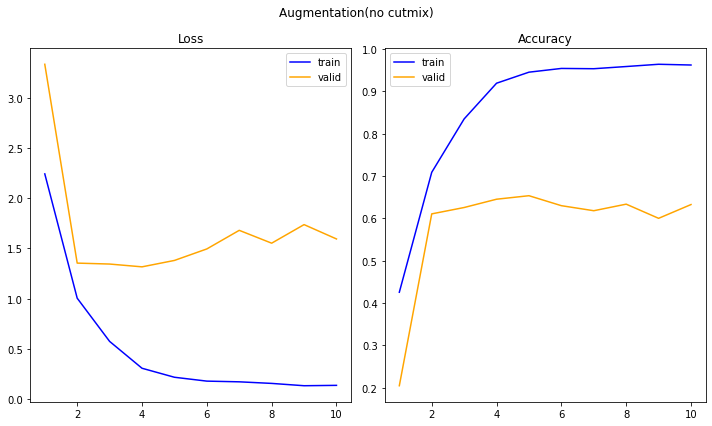

In [13]:
visualization(no_cutmix_aug_history, "Augmentation(no cutmix)")

### 2) CutMix 적용 Augmentation 데이터 학습

In [14]:
cutmix_aug_resnet50 = get_resnet50()
cutmix_aug_resnet50.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                     optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                     metrics=["accuracy"])

csv_logger = tf.keras.callbacks.CSVLogger("./cutmix_aug_resnet50_e10.log")
cutmix_aug_history = cutmix_aug_resnet50.fit(ds_train_cutmix_aug,
                 validation_data=ds_test,
                 steps_per_epoch=int(ds_info.splits["train"].num_examples/16),
                 validation_steps=int(ds_info.splits["test"].num_examples/16),
                 epochs=EPOCH,
                 verbose=1,
                 callbacks=[csv_logger])

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/10
750/750 [==============================] - 182s 231ms/step - loss: 3.7649 - accuracy: 0.2202 - val_loss: 3.4747 - val_accuracy: 0.2072
Epoch 2/10
750/750 [==============================] - 157s 210ms/step - loss: 3.0026 - accuracy: 0.4087 - val_loss: 1.5930 - val_accuracy: 0.5626
Epoch 3/10
750/750 [==============================] - 157s 210ms/step - loss: 2.7290 - accuracy: 0.4902 - val_loss: 1.4301 - val_accuracy: 0.6083
Epoch 4/10
750/750 [==============================] - 157s 210ms/step - loss: 2.5433 - accuracy: 0.5548 - val_loss: 1.3984 - val_accuracy: 0.6180
Epoch 5/10
750/750 [==============================] - 157s 210ms/step - loss: 2.3735 - accuracy: 0.6075 - val_loss: 1.3047 - val_accuracy: 0.6367
Epoch 6/10
750/750 [==============================] - 157s 210ms/step - loss: 2.2548 - accuracy: 0.6391 - val_loss: 1.5265 - val_accuracy: 0.5944
Epoch 7/10
750/750 [==============================] - 157s 210ms/step - loss: 2.1735 - accuracy: 0.6630 - val_loss: 1.4069 -

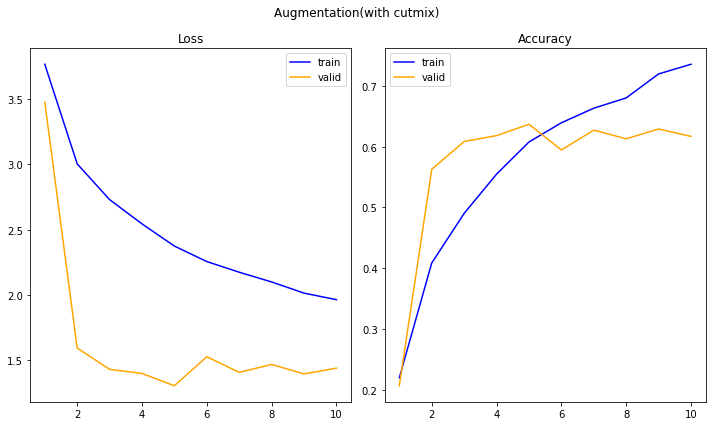

In [15]:
visualization(cutmix_aug_history, "Augmentation(with cutmix)")

cutmit 적용 후가 적용 전보다 천천히 수렴하고 있는것을 볼 수 있다.  
에폭을 더 키워 비교해보자.

### 3) Epoch 20

In [12]:
EPOCH = 20

In [17]:
aug_resnet50_e20 = get_resnet50()
aug_resnet50_e20.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                     optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                     metrics=["accuracy"])

csv_logger = tf.keras.callbacks.CSVLogger("./aug_resnet50_e20.log")
no_cutmix_aug_e20_history = aug_resnet50_e20.fit(
    ds_train_aug,
    validation_data=ds_test,
    steps_per_epoch=int(ds_info.splits["train"].num_examples/16),
    validation_steps=int(ds_info.splits["test"].num_examples/16),
    epochs=EPOCH,
    verbose=1,
    callbacks=[csv_logger]
)

Epoch 1/20
750/750 [==============================] - 164s 209ms/step - loss: 2.2392 - accuracy: 0.4293 - val_loss: 3.2156 - val_accuracy: 0.2400
Epoch 2/20
750/750 [==============================] - 155s 207ms/step - loss: 0.9678 - accuracy: 0.7230 - val_loss: 1.3469 - val_accuracy: 0.6186
Epoch 3/20
750/750 [==============================] - 171s 228ms/step - loss: 0.5084 - accuracy: 0.8551 - val_loss: 1.2759 - val_accuracy: 0.6462
Epoch 4/20
750/750 [==============================] - 156s 208ms/step - loss: 0.3269 - accuracy: 0.9118 - val_loss: 1.3494 - val_accuracy: 0.6425
Epoch 5/20
750/750 [==============================] - 156s 208ms/step - loss: 0.2226 - accuracy: 0.9377 - val_loss: 1.4351 - val_accuracy: 0.6291
Epoch 6/20
750/750 [==============================] - 156s 208ms/step - loss: 0.1897 - accuracy: 0.9483 - val_loss: 1.5157 - val_accuracy: 0.6240
Epoch 7/20
750/750 [==============================] - 155s 207ms/step - loss: 0.1747 - accuracy: 0.9534 - val_loss: 1.5089 -

In [14]:
cutmix_aug_resnet50_e20 = get_resnet50()
cutmix_aug_resnet50_e20.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                     optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                     metrics=["accuracy"])
csv_logger = tf.keras.callbacks.CSVLogger("./cutmix_aug_resnet50_e20.log")
cutmix_aug__e20_history = cutmix_aug_resnet50_e20.fit(ds_train_cutmix_aug,
                 validation_data=ds_test,
                 steps_per_epoch=int(ds_info.splits["train"].num_examples/16),
                 validation_steps=int(ds_info.splits["test"].num_examples/16),
                 epochs=EPOCH,
                 verbose=1,
                 callbacks=[csv_logger])

Epoch 1/20
750/750 [==============================] - 168s 212ms/step - loss: 3.7778 - accuracy: 0.2137 - val_loss: 3.7174 - val_accuracy: 0.1604
Epoch 2/20
750/750 [==============================] - 158s 211ms/step - loss: 3.0170 - accuracy: 0.3982 - val_loss: 1.6685 - val_accuracy: 0.5417
Epoch 3/20
750/750 [==============================] - 158s 211ms/step - loss: 2.7391 - accuracy: 0.4903 - val_loss: 1.4369 - val_accuracy: 0.6133
Epoch 4/20
750/750 [==============================] - 158s 211ms/step - loss: 2.5194 - accuracy: 0.5543 - val_loss: 1.4637 - val_accuracy: 0.5975
Epoch 5/20
750/750 [==============================] - 158s 210ms/step - loss: 2.3646 - accuracy: 0.6060 - val_loss: 1.3606 - val_accuracy: 0.6242
Epoch 6/20
750/750 [==============================] - 157s 210ms/step - loss: 2.2769 - accuracy: 0.6327 - val_loss: 1.3791 - val_accuracy: 0.6350
Epoch 7/20
750/750 [==============================] - 157s 210ms/step - loss: 2.1736 - accuracy: 0.6647 - val_loss: 1.4211 -

In [ ]:
visualization(no_cutmix_aug_e20_history, "Augmentation(no cutmix) Epoch(20)")

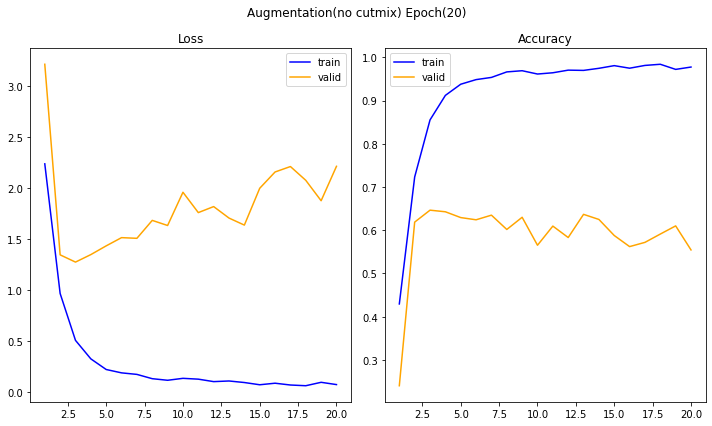

In [40]:
class History:
    def __init__(self, path):
        log = pd.read_csv(path)
        history = {
            "loss": log["loss"].values.tolist(),
            "val_loss": log["val_loss"].values.tolist(),
            "accuracy": log["accuracy"].values.tolist(),
            "val_accuracy": log["val_accuracy"].values.tolist()
        }
        self.history = history
history = History("aug_resnet50_e20.log")
visualization(history, "Augmentation(no cutmix) Epoch(20)")

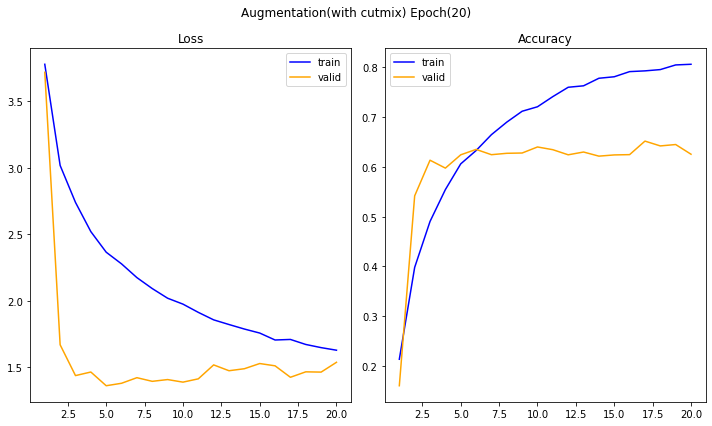

In [17]:
visualization(cutmix_aug__e20_history, "Augmentation(with cutmix) Epoch(20)")